<b>Name - H.M.P.Siriwardana<br>
Index- 190595J<br>
Assignment_02<br>

1

In [50]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import circle_fit as cf
import cv2 as cv

In [3]:

# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )


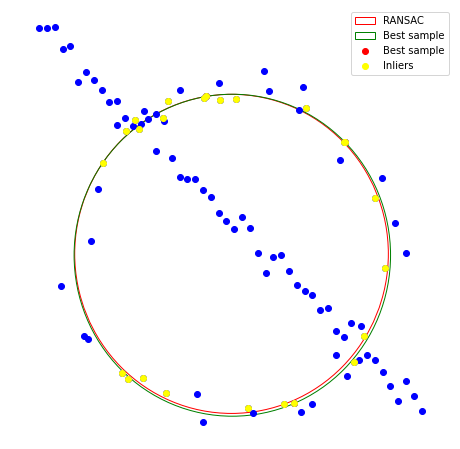

In [46]:
def Circle_RANSAC(points):
    threshold = np.std(points)/16  
    num_iter = np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**3)  
    iter_completed, max_inlierc, selected_model = 0, 0, None

    while iter_completed < num_iter:
        iter_completed += 1
        np.random.shuffle(points)  
        sample_points = points[:3]
        xc,yc,radius,_ = cf.least_squares_circle((sample_points)) 
        center = (xc, yc)
        error = np.abs(radius - np.sqrt(np.sum((center - points[3:])**2, axis=1))) 
        inliers = error <= threshold 
        inlier_c = np.count_nonzero(inliers)


        if inlier_c > max_inlierc: 
            max_inlierc = inlier_c
            inlier_points = []

            for index, inlier in enumerate(inliers): 
                if inlier == True:
                    inlier_points.append(points[3:][index])
            inlier_points = np.array(inlier_points)
            selected_model = (center, radius, sample_points, inlier_points)


    xc,yc,radius,_ = cf.least_squares_circle(np.concatenate((selected_model[2], selected_model[3]), axis=0))
    best_m = ((xc, yc), radius, selected_model[2], selected_model[3])
    return best_m 

best_m = Circle_RANSAC(X_circ)
xc,yc,r,_ = cf.least_squares_circle(best_m[2])

figure, ax = plt.subplots(figsize=(8, 8))
RASNSAC_circle = plt.Circle(best_m[0], best_m[1], fill=False, color='red', label='RANSAC')        
ax.add_artist(RASNSAC_circle)
circle = plt.Circle((xc, yc), r, fill=False, color='green', label='Best sample')    
ax.add_artist(circle)
ax.scatter(best_m[2][:, 0], best_m[2][:, 1], c='red', label='Best sample')
ax.scatter(X_circ[:, 0], X_circ[:, 1], c='blue')
ax.scatter(X_line[:, 0], X_line[:, 1], c='blue')
ax.scatter(best_m[3][:, 0], best_m[3][:, 1], c='yellow', label='Inliers')

plt.legend(loc=1)
plt.xlim(-14, 14)
plt.axis('off')
plt.show()

(-0.5, 1023.5, 767.5, -0.5)

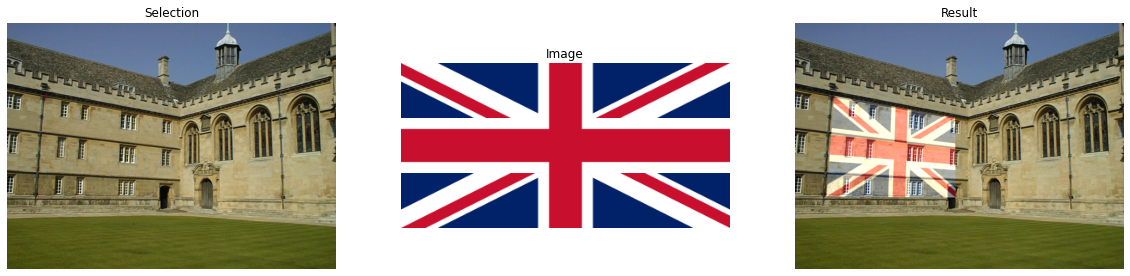

In [20]:
def select_click(event, x, y, flags, params):
    global select_points
    global count
    global image_1

    if event == cv.EVENT_LBUTTONDOWN:
        select_points.append([x, y])
        count += 1

        image_1 = cv.circle(image_1, (x,y), 2, (0, 0, 1), -1)
        cv.imshow("Image", image_1)        
    
    if count == 4:
        cv.destroyAllWindows()
        cv.waitKey(1)

im1 = cv.imread(r"Images/Wadham_college.jpg")
im2 = cv.imread(r"Images/Flag_of_the_United_Kingdom.png")

info = np.iinfo(im1.dtype) 
im1 = im1.astype(np.float64) / info.max

info = np.iinfo(im2.dtype) 
im2 = im2.astype(np.float64) / info.max

image_1 = np.copy(im1)

select_points = []
count = 0

cv.imshow("Image", im1)

cv.setMouseCallback("Image", select_click)
cv.waitKey(0)

if len(select_points) < 4:
    print("You have selected less than 4 points. Please select 4 points")

cv.destroyAllWindows()

X = np.array([
    [0, 0, 1],
    [im2.shape[1], 0, 1],
    [im2.shape[1], im2.shape[0], 1],
    [0, im2.shape[0], 1]
]).T

Y = np.array([
    [select_points[0][0], select_points[0][1], 1],
    [select_points[1][0], select_points[1][1], 1],
    [select_points[2][0], select_points[2][1], 1],
    [select_points[3][0], select_points[3][1], 1],
]).T

O = np.array([
    [0],
    [0],
    [0]
])

xp = []

for i in range(4):
    xp.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
    xp.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

xp = np.array(xp).squeeze().astype(np.float64)

e_vals, e_vectors = np.linalg.eig(xp.T @ xp)
H = e_vectors[:, np.argmin(e_vals)]
H = H.reshape(3, -1)
t_image_2 = cv.warpPerspective(im2, H, (im1.shape[1], im1.shape[0]))

beta = 0.5
result_img = cv.addWeighted(im1, 1, t_image_2, beta, 0.0)
result_img[result_img > 1] = 1
image_1_rgb = cv.cvtColor(image_1.astype(np.float32), cv.COLOR_BGR2RGB) 
image_2_rgb = cv.cvtColor(im2.astype(np.float32), cv.COLOR_BGR2RGB)
result_img_rgb = cv.cvtColor(result_img.astype(np.float32), cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_1_rgb)
ax[1].imshow(image_2_rgb)
ax[2].imshow(result_img_rgb)

ax[0].set_title("Selection")
ax[1].set_title("Image")
ax[2].set_title("Result")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

# 3

a

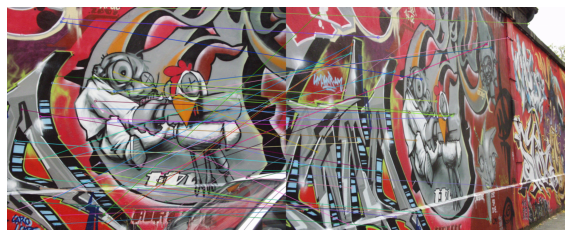

In [26]:

img1, img5 = cv.imread(r"Images\graf\img1.ppm"), cv.imread(r"Images\graf\img5.ppm")
img1, img5 = cv.cvtColor(img1, cv.COLOR_BGR2RGB), cv.cvtColor(img5, cv.COLOR_BGR2RGB)


sift = cv.xfeatures2d.SIFT_create()

kp1, desc1 = sift.detectAndCompute(img1, None)
kp2, desc2 = sift.detectAndCompute(img5, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)
good, pts1, pts2 = [], [], []

for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

good, pts1, pts2 = np.array(good), np.array(pts1), np.array(pts2)
matched_img = cv.drawMatchesKnn(img1, kp1, img5, kp2, good[:50], None, flags=2)

fig, ax = plt.subplots(figsize = (10, 10))
#ax.set_title('SIFT Feature Matching Between Graffiti Images')
ax.imshow(matched_img)
ax.axis('off')
#plt.savefig(r"Report\Images\31.png")
plt.show()

Homography Calculated:
[[ 6.15148651e-01  5.67280933e-02  2.23121595e+02]
 [ 2.15749882e-01  1.15765278e+00 -2.31113011e+01]
 [ 4.74607274e-04 -3.77424514e-05  1.00000000e+00]]
Homography :
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]
Sum of squared differences:7.452615107508754


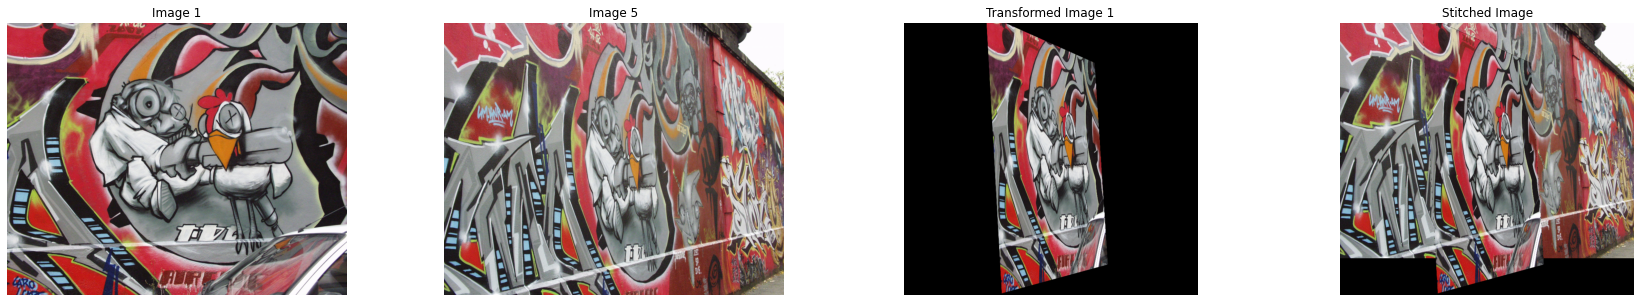

In [51]:
def homography(X, Y):
    O = np.array([[0],[0],[0]])

    A = []

    for i in range(4):
        A.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
        A.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

    A = np.array(A).squeeze().astype(np.float64)

    e_vals, e_vectors = np.linalg.eig(A.T @ A)
    H = e_vectors[:, np.argmin(e_vals)]
    H = H.reshape(3, -1)

    return H
def inlier_c(X_full, Y_full, H, t, X_inliers, Y_inliers):
    count = 0
    t_X_full = H @ X_full
    t_X_full = t_X_full / t_X_full[2,:]

    error = np.sqrt(np.sum(np.square(t_X_full - Y_full), axis=0))
    inlier_indices = np.where(error <= t)[0]

    X_inliers = np.concatenate((X_inliers, X_full[:,inlier_indices]), axis=1)
    Y_inliers = np.concatenate((Y_inliers, Y_full[:,inlier_indices]), axis=1)

    count = inlier_indices.shape[0]
    return count, X_inliers, Y_inliers

def sift_f(img1p, img2p):
    img1 = cv.imread(img1p)
    img5 = cv.imread(img2p)

    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma =1)

    kp1, dp1 = sift.detectAndCompute(img1_gray, None) 
    kp2, dp2 = sift.detectAndCompute(img5_gray, None)  

    kp_img_1 = np.zeros(img1_gray.shape)
    kp_img_5 = np.zeros(img5_gray.shape)

    kp_img_1 = cv.drawKeypoints(img1_gray, kp1, kp_img_1)
    kp_img_5 = cv.drawKeypoints(img5_gray, kp2, kp_img_5)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(dp1,dp2,k=2)

    gm = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            gm.append([m])

    matches_img = np.zeros(img1_gray.shape)
    matches_img_fifty = np.zeros(img1_gray.shape)

    matches_img = cv.drawMatchesKnn(img1_gray, kp1, img5_gray, kp2, gm, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    gm = np.squeeze(np.array(gm))

    return gm, kp1, kp2
    

def RANSAC(img1p, img2p, t, d, N):

    s = 4
    bf_homography = None
    b_inlier_c = 0
    bf_X_inliers = None
    bf_Y_inliers = None
    count_db = []

    matches, kp1, kp2 = sift_f(img1p, img2p)

    X_full = np.zeros((len(matches), 3))
    Y_full = np.zeros((len(matches), 3))

    for i, match in enumerate(matches):
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt

        X_full[i,:] = np.array([p1[0], p1[1], 1])
        Y_full[i,:] = np.array([p2[0], p2[1], 1])
    
    X_full = X_full.T
    Y_full = Y_full.T

    for _ in range(N):
        x = []

        for i in range(s):
            hold_idx = np.random.randint(0, len(matches))
            
            if len(x) == 0:
                x.append(hold_idx)
            elif hold_idx == x[-1]:                
                while hold_idx == x[-1]:
                    hold_idx = np.random.randint(0, len(matches))
                
                x.append(hold_idx)
            else:
                x.append(hold_idx)
        
        X = np.zeros((4,3))
        Y = np.zeros((4,3))

        for i, idx in enumerate(x):
            match = matches[idx]

            p1 = kp1[match.queryIdx].pt
            p2 = kp2[match.trainIdx].pt

            X[i,:] = np.array([p1[0], p1[1], 1])
            Y[i,:] = np.array([p2[0], p2[1], 1])

        X = X.T
        Y = Y.T

        X_inliers = np.zeros((3, 1))
        Y_inliers = np.zeros((3, 1))
    
        H = homography(X, Y)        

        count, X_inliers, Y_inliers = inlier_c(X_full, Y_full, H, t, X_inliers, Y_inliers)

        X_inliers = np.delete(X_inliers, 0, axis=1)
        Y_inliers = np.delete(Y_inliers, 0, axis=1)

        count_db.append(count)

        if count > b_inlier_c:
            bf_homography = H
            b_inlier_c = count
            bf_X_inliers = X_inliers
            bf_Y_inliers = Y_inliers
    
    return bf_homography, b_inlier_c, count_db, bf_X_inliers, bf_Y_inliers

    
img1, img5 = cv.imread(r"Images\graf\img1.ppm"), cv.imread(r"Images\graf\img5.ppm")
with open("Images/graf/H1to5p", "r") as txt_file:
    orginal_hom = txt_file.read()
    orginal_hom = orginal_hom.split('\n')
    orginal_hom.pop()

    for i in range(len(orginal_hom)):
        orginal_hom[i] = list(map(float, orginal_hom[i].strip().split()))
    
    orginal_hom = np.array(orginal_hom)

path = r"Images/graf/"
H_db = []

for i in range(1, 5):
    img1_path = path + "img" + str(i) + ".ppm"
    img2_path = path + "img" + str(i+1) + ".ppm"

    H, count, count_db, best_fit_X_inliers, best_fit_Y_inliers = RANSAC(img1_path, img2_path, 1, 20, 10000)

    H_db.append(H)

H1to5 = H_db[0]

for i in range(1, len(H_db)):
    H1to5 = H_db[i] @ H1to5

imgx = cv.imread("Images/graf/img1.ppm")
imgx = cv.warpPerspective(imgx, H1to5, dsize=(img1.shape[1], img1.shape[0]+100))

t_img_1 = np.copy(imgx)

for i in range(imgx.shape[0]):
    for j in range(imgx.shape[1]):
        if np.all(imgx[i,j] == 0) and i < img5.shape[0] and j < img5.shape[1]:
            imgx[i,j] = img5[i,j]

fig, ax = plt.subplots(1, 4, figsize=(30, 5))

ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(t_img_1, cv.COLOR_BGR2RGB))
ax[3].imshow(cv.cvtColor(imgx, cv.COLOR_BGR2RGB))

ax[0].set_title("Image 1")
ax[1].set_title("Image 5")
ax[2].set_title("Transformed Image 1")
ax[3].set_title("Stitched Image")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")


cal_hom =  H1to5 / H1to5[2,2]
print(f"Homography Calculated:\n{cal_hom}")
print(f"Homography :\n{actual_H}")
error = np.sum(np.square(cal_hom - actual_H))
print(f"Sum of squared differences:{error}")